In [1]:
%matplotlib inline
%precision 2
import warnings; warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt

# Datasets

Here we generate 3 syntethic datasets that will be used to demonstrate some visualisation tools.

In [2]:
from sklearn.datasets import make_blobs

dataset_binary = make_blobs(n_samples=10000, centers=5,
                            n_features=2,
                            random_state=42)

dataset_binary[1][:] = dataset_binary[1] > 2

## Another dataset to test
#from sklearn.datasets import make_classification
#dataset_binary = make_classification(n_samples=10000, n_classes=2,
#                                     n_features=2, n_redundant=0,
#                                     random_state=42)

Each dataset is just composed by the features $x$ and labels $y$. The following is a scatterplot of the binary dataset.

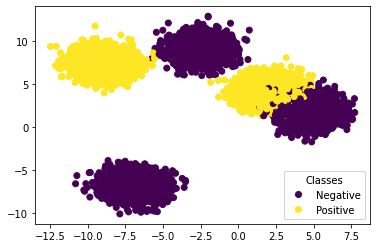

In [3]:
x, y = dataset_binary
fig, ax = plt.subplots()
scatter = ax.scatter(x[:, 0], x[:, 1], c=y)
handles, labels = scatter.legend_elements()
labels = ['Negative', 'Positive']
legend = ax.legend(handles, labels,
                    loc="lower right", title="Classes")
ax.add_artist(legend)

# Reliability diagram

We will first train a classifier, and a calibrator on top of it. We will then visualise the reliability diagram.

## Binary (only the positive class)

In [4]:
from sklearn.model_selection import train_test_split

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [5]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

Text(0.5, 1.0, 'Predicted probabilities')

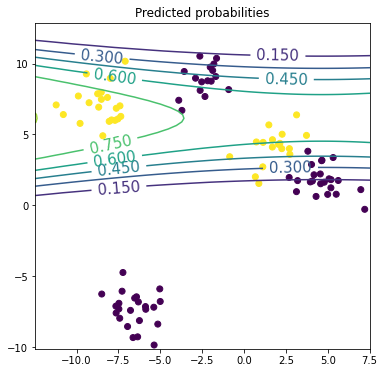

In [6]:
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
Y = clf.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots(figsize=(6, 6))
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape))
ax.clabel(CS, inline=1, fontsize=15)
ax.scatter(x[:100, 0], x[:100, 1], c=y[:100])
ax.set_title('Predicted probabilities')

Text(0.5, 0, 'samples per bin')

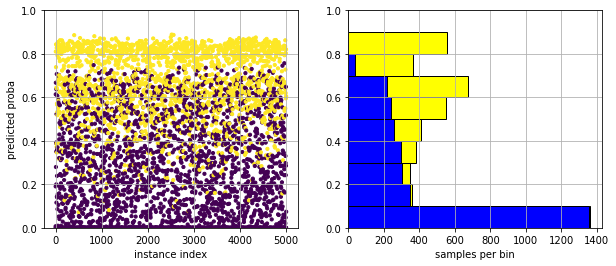

In [7]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)

p_clf = clf.predict_proba(x_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(range(len(p_clf[:,1])), p_clf[:,1], c=y_test, s=10)
ax1.set_ylim(0, 1)
ax1.grid()
ax1.set_xlabel('instance index')
ax1.set_ylabel('predicted proba')
ax2.hist([p_clf[y_test == 0, 1],
          p_clf[y_test == 1, 1]],
         bins=bins, orientation='horizontal', stacked=True,
         color=['blue', 'yellow'], edgecolor='black')
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_xlabel('samples per bin')

Text(0, 0.5, 'Samples per bin')

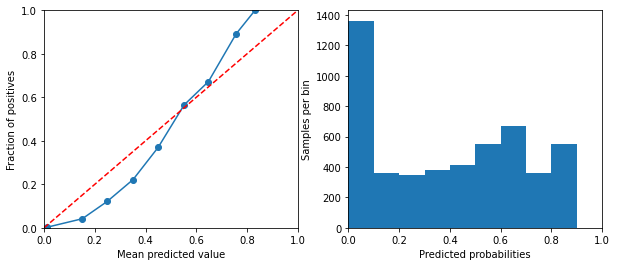

In [8]:
digitized = np.digitize(p_clf[:, 1], bins=bins)
pred_means = [p_clf[:, 1][digitized == i].mean() for i in range(1, n_bins+1)]
y_means = [y_test[digitized == i].mean() for i in range(1, n_bins+1)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(pred_means, y_means, 'o-')
ax1.plot([0, 1], [0, 1], 'r--')
ax1.set_xlim(0, 1)
ax1.set_xlabel('Mean predicted value')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Fraction of positives')

ax2.hist(p_clf[:, 1], bins=bins)
ax2.set_xlim(0, 1)
ax2.set_xlabel('Predicted probabilities')
ax2.set_ylabel('Samples per bin')

We can train a different classifier in order to compare with the previous one

In [9]:
from sklearn.neighbors import KNeighborsClassifier

clf2 = KNeighborsClassifier(n_neighbors=10)
clf2.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In the PyCalib library we can directly call a function to plot the reliability diagram for a list of output scores, in this case we will demonstrate with the previously trained classifiers

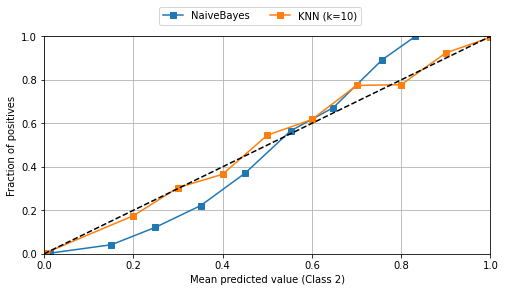

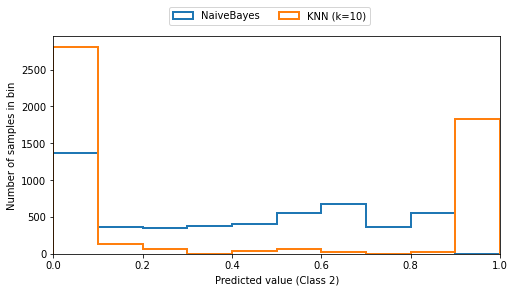

In [10]:
from pycalib.visualisations import plot_reliability_diagram

scores_list = [clf.predict_proba(x_test),
               clf2.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', 'KNN (k=10)'), histogram=True)

We can also see a visualisation that emphasizes the gaps between the proportions of positives of each bin and the perfect diagonal.

In this case we will show it for the first classifier.

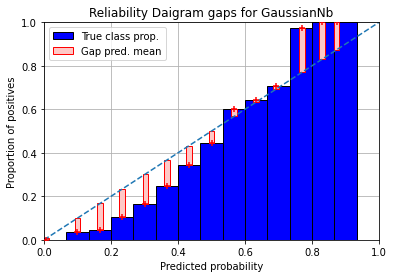

In [11]:
from pycalib.visualisations import plot_binary_reliability_diagram_gaps

est_scores = clf.predict_proba(x_test)
fig, ax = plot_binary_reliability_diagram_gaps(y_test, est_scores, n_bins=15)
_ = ax.set_title('Reliability Daigram gaps for GaussianNb')

We can compute the Expected Calibration Error (ECE)

In [12]:
from pycalib.metrics import ECE

print('ECE = ', ECE(est_scores, y_test))

ECE =  0.14417963527383126


## Multiclass

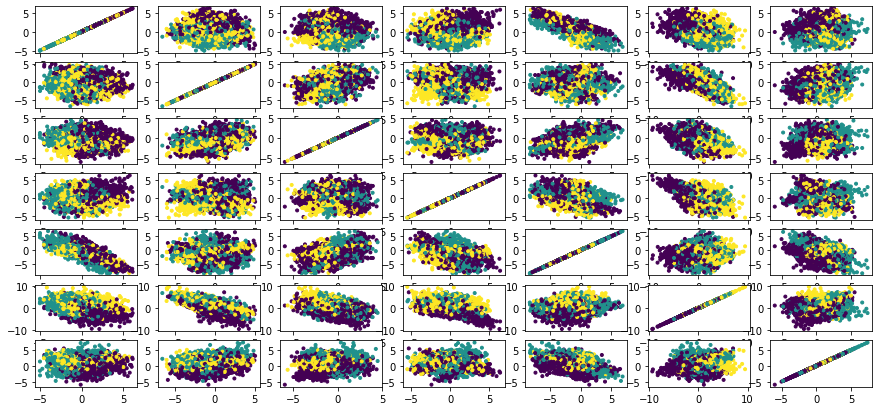

In [13]:
from sklearn.datasets import make_classification

n_features = 7
dataset_ternary = make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=3,
                                    n_features=n_features,
                                    n_informative=5,
                                    random_state=42)

x, y = dataset_ternary

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(x[:,i], x[:,j], c=y, marker='.')

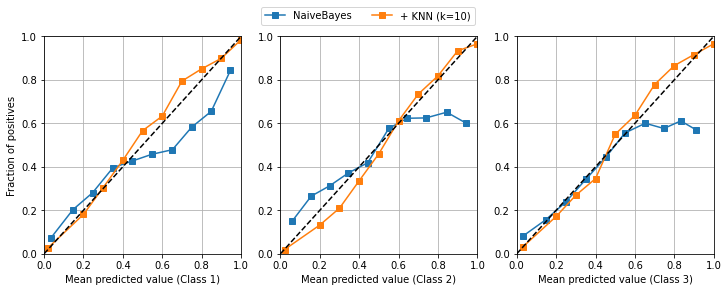

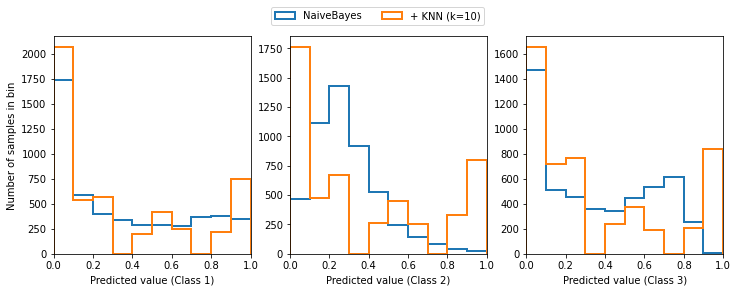

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)
clf2 = KNeighborsClassifier(n_neighbors=10)
clf2.fit(x_train, y_train)

scores_list = [clf.predict_proba(x_test),
          clf2.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ KNN (k=10)'),
                             histogram=True)

In the multiclass case we can focus on the most confident score per sample, and plot only the proportion of correct predictions in each bin.

The following plots only show the results for the first classifier.

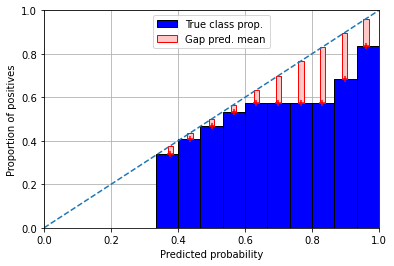

In [15]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)

probas = clf.predict_proba(x_test)
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=False)

We can compute the confidence-ECE which only computes expected gap size in the previous plot

$$
    \mathsf{confidence{-}ECE}  = \sum_{i=1}^M \frac{|B_{i}|}{N} |\bar{y}(B_{i}) - \bar{p}(B_{i})|
$$

In [16]:
from pycalib.metrics import conf_ECE

print('conf-ECE = ', conf_ECE(probas, y_test))

conf-ECE =  0.11480434701742057


or the maximum gap with the confidence-MCE:

$$
\mathsf{confidence{-}MCE} = \max_{i \in \{1, \ldots, M\}} |\bar{y}(B_i) - \bar{p}(B_i)|
$$

In [17]:
from pycalib.metrics import conf_MCE

print('conf-MCE = ', conf_MCE(probas, y_test))

conf-MCE =  0.25656568798134005


Instead of only showing the most confident prediction, we can show the scores for each class

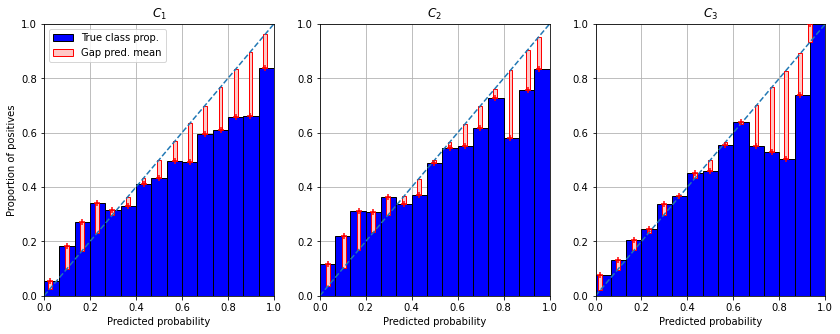

In [18]:
fig = plt.figure(figsize=(14, 5))
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=True, fig=fig)

With the previous figure we can get an intuition about how the classwise-ECE is computed, as the expected gap size across all the classes

$$
\mathsf{classwise{-}ECE}  = \frac{1}{K}\sum_{j=1}^K \sum_{i=1}^M \frac{|B_{i,j}|}{N} |\bar{y}_j(B_{i,j}) - \bar{p}_j(B_{i,j})|,
$$

In [19]:
from pycalib.metrics import classwise_ECE

classwise_ECE(probas, y_test)

0.24375711725299157

In [20]:
from pycalib.metrics import pECE

pECE(probas, y_test, samples=1000)

0.00

the classwise-MCE needs to be added

# Calibration maps

Calibration maps show the transformation that the calibrator performs to the classifier's scores. This is a map function from $C$ to $C$ where $C$ is the number of classes. In the binary case it is comonly shown for the positive class

## Binary

We will load again the binary dataset that we created earlier

In [21]:
x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

Now we will need a calibrator in order to show the mapping function. We will train here a classifier with a calibrator on top.

In [22]:
from pycalib.models import CalibratedModel, IsotonicCalibration

cal = CalibratedModel(GaussianNB(), IsotonicCalibration())
cal.fit(x_train, y_train)

CalibratedModel(base_estimator=GaussianNB())

In the binary case the calibration map corresponds to a 1 to 1 function that can be visualised  in two dimensions with the scores of the classifier in the $x$ axis, and the corresponding probabilities from the calibrator in the $y$ axis.

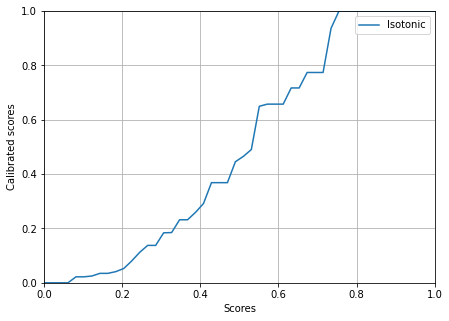

In [23]:
scores_linspace = np.linspace(0, 1, 50)
scores_linspace = np.vstack((1-scores_linspace, scores_linspace)).T
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
calibrated = cal.calibrator.predict_proba(scores_linspace)
ax.plot(scores_linspace[:, 1], calibrated[:, 1], label='Isotonic')
ax.legend()
ax.set_xlabel('Scores')
ax.set_ylabel('Calibrated scores')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()

Notice the similarity to the reliability diagram of the classifier, as the calibrator is trying to correct the misscalibration by fitting the scores as best as possible.

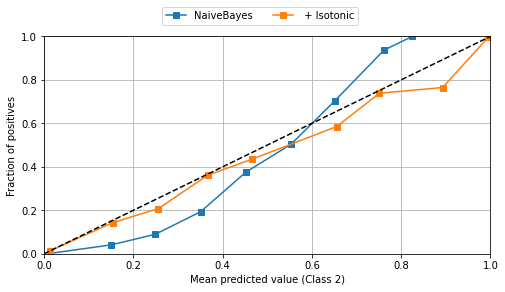

In [24]:
_ = plot_reliability_diagram(y_test, (cal.base_estimator.predict_proba(x_test), cal.predict_proba(x_test)),
                             legend=('NaiveBayes', ' + Isotonic'), histogram=False)

## Ternary Calibration maps

It is possible to visualise a calibration map for ternary classification problems. We will start by loading the ternary dataset, and training a classifier and a calibrator on top.

In [25]:
from dirichletcal import FullDirichletCalibrator

x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

CalibratedModel(base_estimator=GaussianNB())

With 3 classes the calibration map corresponds to a function from 3 to 3 dimensions. As this is difficult to visualise we propose several approaches that show part of the map.

We will first obtain a 2D mesh in the simplex, trying to cover most of the space

In [26]:
from pycalib.visualisations.barycentric import get_mesh_bc
P_bc_grid = get_mesh_bc(subdiv=4)

Now we will obtain the predicted probabilities output by our calibrator for each of the points in the mesh.

In [27]:
calibrated = cal.calibrator.predict_proba(P_bc_grid)

One way is to consider that the input and output scores live in a 2D simplex. This means that we can visualise the mapping from an input and output scores as a 2D coordinates. Then we will show both coordinates as the begining and end of an arrow.

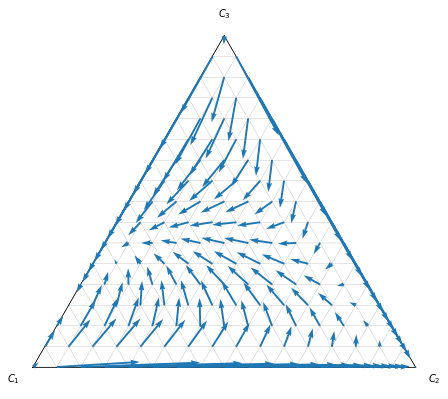

In [28]:
from pycalib.visualisations.barycentric import draw_calibration_map

fig = plt.figure(figsize=(7, 7))
_ = draw_calibration_map(P_bc_grid, calibrated,  subdiv=4, fig=fig)

We can also paint the arrows in three different colors, one per class. We will paint them indicating the most confident class at the tip of the arrow (output of the calibrator).

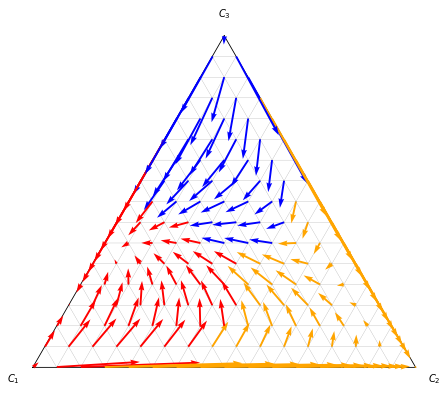

In [29]:
color_list = ['Red', 'Orange', 'Blue']
color = [color_list[i] for i in calibrated.argmax(axis=1).astype(int)]

fig = plt.figure(figsize=(7, 7))
_ = draw_calibration_map(P_bc_grid, calibrated, color=color,  subdiv=4, fig=fig)

Another way is to show 3 calibration maps from 3 to 1 dimension. Each calibration map shows the full input score to the calibrator, and only one of the classes' output. The input then will be shown as the position in a 2D simplex, while the output is shown as a heatmap.

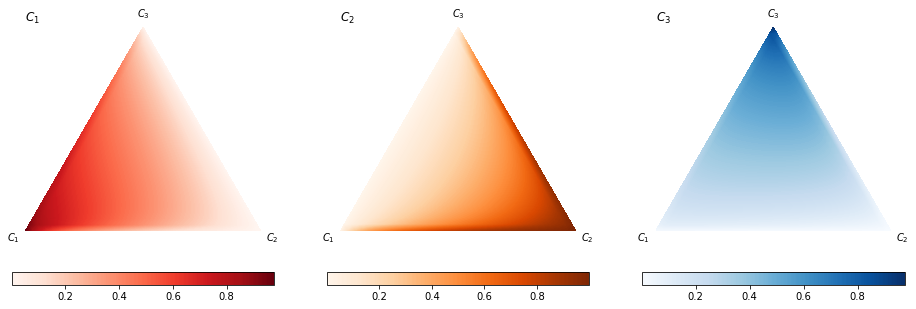

In [30]:
from pycalib.visualisations.ternary import draw_func_contours, plot_converging_lines_pvalues, get_converging_lines

cmap_list = ['Reds', 'Oranges', 'Blues']

fig = plt.figure(figsize=(16, 5))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 3, i+1)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=cmap_list[i])

Notice that we can cut arbitrary sections on the previous calibration maps and obtain cross-sections that can be visualised as binary calibration maps.

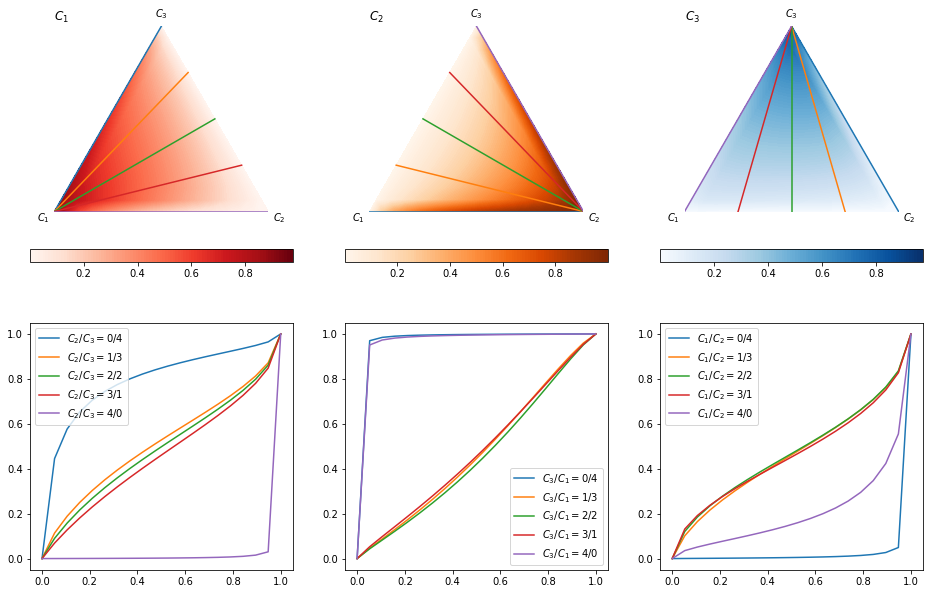

In [31]:
from pycalib.visualisations.ternary import plot_converging_lines_pvalues, get_converging_lines

fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)

    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=cmap_list[i],
                       nlevels=100, subdiv=4, draw_lines=5, class_index=i)

    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=20, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

In the following figure we show side by side the previous calibration maps

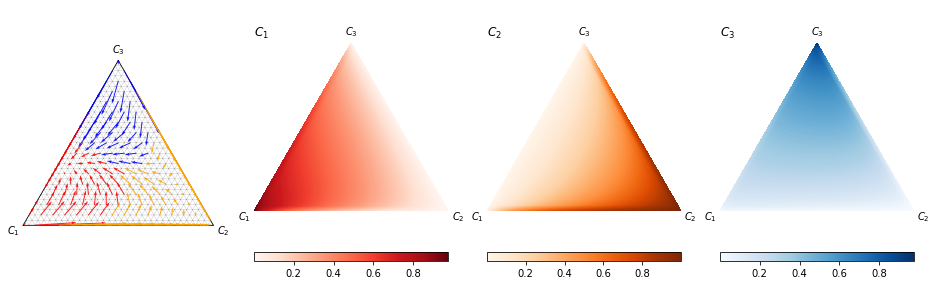

In [32]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 4, 1)
fig = draw_calibration_map(P_bc_grid, calibrated, color=color, subdiv=5, fig=fig, ax=ax, alpha=0.9)

for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(1, 4, i+2)
    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=cmap_list[i])